In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import json
import matplotlib
import os
import random
import torch

from collections import Counter
from itertools import islice
from sklearn.utils import shuffle
from tqdm import tqdm, trange
from torch.optim import Adam
from torch.utils.data import TensorDataset

from models.Encoder import *
from models.Decoder import *
from models.utils import *
from utils import *

# set fixed random seed to reproduce results
np.random.seed(42)
random.seed(42)

%matplotlib inline

GPU is available
GPU is available


Using TensorFlow backend.


# Experiment 1b

In [9]:
# define experiment
exp='/exp_1'

# define number of iterations
n_iters = 20000

# define batch size
batch_size = 32

In [10]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# load dataset into memory, and get w2idx, idx2w, w2freq dictionaries and lists of input and output sentences
cmd_vocab, w2i_cmds, i2w_cmds, cmds_train, act_vocab, w2i_acts, i2w_acts, acts_train = load_dataset(exp=exp, split='/train')
_, _, _, cmds_test, _, _, _, acts_test = load_dataset(exp=exp, split='/test')

In [12]:
## create input and output language pairs ##

# training
train_cmd_act_pairs = create_pairs(cmds_train, acts_train)
print("Number of train source-target pairs: {}".format(len(train_cmd_act_pairs)))

# testing
test_cmd_act_pairs = create_pairs(cmds_test, acts_test)
print("Number of test source-target pairs: {}".format(len(test_cmd_act_pairs)))

Number of train source-target pairs: 16728
Number of test source-target pairs: 4182


In [13]:
# show random train command-action pair
random_pair = random.choice(train_cmd_act_pairs)
print("Command: {}".format(random_pair[0]))
print("Action: {}".format(random_pair[1]))

Command: ['jump', 'around', 'left', 'and', 'turn', 'right', 'thrice']
Action: ['I_TURN_LEFT', 'I_JUMP', 'I_TURN_LEFT', 'I_JUMP', 'I_TURN_LEFT', 'I_JUMP', 'I_TURN_LEFT', 'I_JUMP', 'I_TURN_RIGHT', 'I_TURN_RIGHT', 'I_TURN_RIGHT']


In [14]:
# show random test command-action pair
random_pair = random.choice(test_cmd_act_pairs)
print("Command: {}".format(random_pair[0]))
print("Action: {}".format(random_pair[1]))

Command: ['turn', 'right', 'thrice', 'after', 'look', 'opposite', 'left', 'twice']
Action: ['I_TURN_LEFT', 'I_TURN_LEFT', 'I_LOOK', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_LOOK', 'I_TURN_RIGHT', 'I_TURN_RIGHT', 'I_TURN_RIGHT']


In [16]:
### Hyperparameters for training ###

# source language (i.e., commands) vocabulary size |V_source|
in_size = len(w2i_cmds)

# target language (i.e., actions) vocabulary size |V_target|
out_size = len(w2i_acts)

# size of word embeddings
emb_size = 20

# size of hidden units
hidden_size = 100

# number of layers
n_layers = 2

# learning rate
lr = 1e-3

# layer dropout rate
dropout_p = 0.5

# define whether encoder is uni- or bidirectional
bidir = False

# number of epochs
n_epochs = 10 # 10-15 epochs (20.000 iterations each) seem to be sufficient until model convergence

## Train and test over different numbers of distinct source-target pairs (1b)

In [ ]:
## experiment 1b train and test loop over pre-defined ratios ##

#train_cmd_act_pairs = list(zip(cmds_train, acts_train))
ratios = np.array([0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64])
accs_per_ratio = {}

for ratio in ratios:
    train_samples = sample_distinct_pairs(train_cmd_act_pairs, ratio)
    print("-------------------------------------------------")
    print("Current percentage of total commands used for training: {}%".format(ratio*100))
    print("Number of distinct examples shown during training: {}".format(len(train_samples)))
    print("-------------------------------------------------")
    cmds_train, acts_train = zip(*train_samples)
    
    cmds_train_idx, acts_train_idx, input_lengths_train, masks = pairs2idx(cmds_train, acts_train, w2i_cmds, w2i_acts, padding=True, training=True)
    cmds_test_idx, acts_test_idx, input_lengths_test = pairs2idx(cmds_test, acts_test, w2i_cmds, w2i_acts, padding=True, training=False)
    
    # create train and test data loaders
    train_dl = create_batches(cmds_train_idx, acts_train_idx, input_lengths_train, batch_size=batch_size, masks=masks, split='train', num_samples=n_iters)
    test_dl = create_batches(cmds_test_idx, acts_test_idx, input_lengths_test, batch_size=batch_size, split='test')
    
    # instantiate new encoder and decoder for each ratio
    encoder = EncoderLSTM(in_size, emb_size, hidden_size, n_layers, dropout=dropout_p, bidir=bidir)
    decoder = DecoderLSTM(emb_size, hidden_size, out_size, n_layers, dropout=dropout_p)
    
    # move models to GPU
    encoder.cuda()
    decoder.cuda()
    
    # train
    train_losses, train_accs, encoder, decoder = train(train_dl, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts, encoder, decoder,
                                                       epochs=n_epochs, batch_size=batch_size, learning_rate=lr)
    # test
    test_acc = test(test_dl, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts, encoder, decoder, batch_size=batch_size)
    
    # save results
    accs_per_ratio[ratio] = test_acc

-------------------------------------------------
Current percentage of total commands used for training: 1.0%
Number of distinct examples shown during training: 167
-------------------------------------------------


Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 0.7111444229309538
Acc: 0.0007267441860465116

Command: turn around right thrice after turn around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS> <EOS>

True sent length: 25
Pred sent length: 25

Loss: 0.3476739645556167
Acc: 0.012219217970049916

Command: look around right thrice and turn opposite right twice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_R

Epoch:  10%|███████▌                                                                   | 1/10 [06:03<54:32, 363.62s/it]

Loss: 0.2360903539599102
Acc: 0.10340531561461794

Command: run around left thrice after turn around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>

True sent length: 37
Pred sent length: 37

Loss: 0.20455298312938028
Acc: 0.18614808652246256

Command: jump around 

Epoch:  20%|███████████████                                                            | 2/10 [12:13<48:44, 365.57s/it]

Loss: 0.10209982819816532
Acc: 0.4069767441860465

Command: look around right thrice and look around right twice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK <EOS>

True sent length: 41
Pred sent length: 41


Epoch:  30%|██████████████████████▌                                                    | 3/10 [18:18<42:37, 365.42s/it]

Loss: 0.329732285921353
Acc: 0.6631021594684385

Command: look opposite right thrice after look opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 19
Pred sent length: 19

Loss: 0.0749441800911862
Acc: 0.6985232945091514

Command: turn around left twice after run opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LE

Epoch:  40%|██████████████████████████████                                             | 4/10 [24:24<36:32, 365.45s/it]

Loss: 0.05712978628876988
Acc: 0.8100083056478405

Command: run opposite right thrice after walk opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>

True sent length: 19
Pred sent length: 19

Loss: 0.050197520972656944
Acc: 0.8213394342762064

Command: turn around left thrice and run opposite right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEF

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [30:22<30:16, 363.35s/it]

Loss: 0.059144973536501846
Acc: 0.8821636212624585

Command: walk around left thrice and turn right thrice <EOS> <PAD>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT <EOS>

True sent length: 28
Pred sent length: 28

Loss: 0.021750402436344806
Acc: 0.8991264559068219

Command: turn around left twice after run opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [36:28<24:16, 364.13s/it]

Loss: 0.043190801367690525
Acc: 0.9493355481727574

Command: look opposite right thrice after turn opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.00745308936391785
Acc: 0.9460794509151415

Command: jump around left twice after run opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [42:29<18:09, 363.02s/it]

Loss: 0.039529668185261324
Acc: 0.9695805647840532

Command: walk around right thrice after run around right thrice <EOS>
True action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIG

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [48:30<12:04, 362.40s/it]

Loss: 0.003727244962214873
Acc: 0.9746677740863787

Command: turn opposite left thrice after jump around left twice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>

True sent length: 23
Pred sent length: 23

Loss: 0.0016256088564481931
Acc: 0.9826331114808652

Command: run around left thrice after turn around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RU

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [54:33<06:02, 362.56s/it]

Loss: 0.0011154021775371388
Acc: 0.9886835548172758

Command: look around left twice after jump around right thrice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>

True sent length: 41
Pred sent length: 41

Loss: 0.0089

Epoch: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [1:00:30<00:00, 363.04s/it]


Current test acc: 0.027573529411764705

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS> <EOS> <EOS> <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.023824257425742575

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 0.7837075410794666
Acc: 0.00020764119601328904

Command: walk opposite left thrice after jump around right twice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_JUMP I_TURN_LEFT I_JUMP I_JUMP I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT

True sent length: 26
Pred sent length: 26

Loss: 0.4371968222661845
Acc: 0.004159733777038269

Command: jump opposite left thrice and run around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TU

Epoch:  10%|███████▌                                                                   | 1/10 [05:54<53:12, 354.76s/it]

Loss: 0.780942147231657
Acc: 0.07423172757475083

Command: turn around right twice after run opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS> <EOS>

True sent length: 15
Pred sent length: 15

Loss: 0.2729898916785036
Acc: 0.1413789517470882

Command: look opposite right thrice and turn opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN

Epoch:  20%|███████████████                                                            | 2/10 [11:42<47:00, 352.54s/it]

Loss: 0.15002382449590815
Acc: 0.34593023255813954

Command: look opposite left twice after jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 13
Pred sent length: 13

Loss: 0.2695368609416324
Acc: 0.4090058236272879

Command: turn around left thrice after walk opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I

Epoch:  30%|██████████████████████▌                                                    | 3/10 [17:27<40:52, 350.35s/it]

Loss: 0.20688502421231197
Acc: 0.581187707641196

Command: turn around left thrice after walk opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>

True sent length: 19
Pred sent length: 19

Loss: 0.05422770000919367
Acc: 0.6348793677204659

Command: walk opposite right thrice after run around right thrice <EOS>
True action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT 

Epoch:  40%|██████████████████████████████                                             | 4/10 [23:20<35:07, 351.31s/it]

Loss: 0.3669321673155139
Acc: 0.7662998338870431

Command: turn opposite left twice after look around right twice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS> <EOS>

True sent length: 21
Pred sent length: 21

Loss: 0.05292373347247756
Acc: 0.8017886855241264

Command: walk opposite right twice and turn opposite left twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>

T

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [29:24<29:34, 354.90s/it]

Loss: 0.18779920438614753
Acc: 0.882890365448505

Command: walk opposite right twice after walk opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.032027996358482906
Acc: 0.8959546589018302

Command: look around left twice and jump around right thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP 

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [35:28<23:51, 357.86s/it]

Loss: 0.01749434131803455
Acc: 0.9136212624584718

Command: turn around right twice after run around left twice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>

True sent length: 25
Pred sent length: 25

Loss: 0.0145311603455903
Acc: 0.9305844425956739

Command: turn around right twice after run around left twice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TU

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [41:29<17:55, 358.53s/it]

Loss: 0.0063093691849611154
Acc: 0.9432101328903655

Command: look opposite left twice after jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 13
Pred sent length: 13

Loss: 0.006925205605921292
Acc: 0.9562707986688852

Command: run opposite right thrice after run opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>

Tr

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [47:24<11:55, 357.53s/it]

Loss: 0.013034019677572672
Acc: 0.9634551495016611

Command: jump opposite left thrice and look opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.010840337709151097
Acc: 0.9641222961730449

Command: run opposite left thrice and walk opposite right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [53:24<05:58, 358.32s/it]

Loss: 0.02471177681678082
Acc: 0.9606519933554817

Command: look around left thrice and look opposite right twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.009588288655017986
Acc: 0.9703618968386023

Command: look around left twice and walk opposite left twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [59:31<00:00, 357.19s/it]


Current test acc: 0.17401960784313725

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS> <EOS> <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.17172029702970298

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TU

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 0.6755060081002057
Acc: 0.0004152823920265781

Command: turn around left twice and turn opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_LOOK <EOS>

True sent length: 13
Pred sent length: 13

Loss: 0.46301155074816086
Acc: 0.005407653910149751

Command: jump around left thrice after run around left thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP

Epoch:  10%|███████▎                                                                 | 1/10 [10:33<1:35:02, 633.57s/it]

In [19]:
# save results in .json file
with open('./results/experiment_1b_mini_batch.json', 'w') as json_file:
      json.dump(accs_per_ratio, json_file)

In [5]:
# load results from experiment 1b (mini-batch training)
with open('./results/experiment_1b_mini_batch.json') as json_file:
    accs_per_ratio = json.load(json_file)

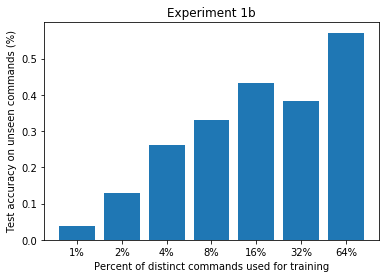

<Figure size 432x288 with 0 Axes>

In [7]:
ratios, test_accs = zip(*accs_per_ratio.items())
plt.bar(ratios, test_accs)
plt.xlabel('Percent of distinct commands used for training')
plt.ylabel('Test accuracy on unseen commands (%)')
plt.xticks(ticks=ratios, labels=list(map(lambda rat: str(int(float(rat) * 100)) + '%', ratios)))
plt.title('Experiment 1b (mini-batch)')
plt.savefig('./Paper/Plots/experiment_1b_mini_batch.png')
plt.show()
plt.clf()

In [ ]:
# load results from experiment 1b
with open('./results/experiment_1b.json') as json_file:
    accs_per_ratio = json.load(json_file)

In [ ]:
ratios, test_accs = zip(*accs_per_ratio.items())
plt.bar(ratios, test_accs)
plt.xlabel('Percent of distinct commands used for training')
plt.ylabel('Test accuracy on unseen commands (%)')
plt.xticks(ticks=ratios, labels=list(map(lambda rat: str(int(float(rat) * 100)) + '%', ratios)))
plt.title('Experiment 1b (online)')
plt.savefig('./Paper/Plots/experiment_1b_mini_batch.png')
plt.show()
plt.clf()